# 주제 : 데이터 분석으로 심부전증을 예방할 수 있을까?
----------
    
## 데이터 소개
    
    - 각 파일의 컬럼은 아래와 같습니다.
    age: 환자의 나이
    anaemia: 환자의 빈혈증 여부 (0: 정상, 1: 빈혈)
    creatinine_phosphokinase: 크레아틴키나제 검사 결과
    diabetes: 당뇨병 여부 (0: 정상, 1: 당뇨)
    ejection_fraction: 박출계수 (%)
    high_blood_pressure: 고혈압 여부 (0: 정상, 1: 고혈압)
    platelets: 혈소판 수 (kiloplatelets/mL)
    serum_creatinine: 혈중 크레아틴 레벨 (mg/dL)
    serum_sodium: 혈중 나트륨 레벨 (mEq/L)
    sex: 성별 (0: 여성, 1: 남성)
    smoking: 흡연 여부 (0: 비흡연, 1: 흡연)
    time: 관찰 기간 (일)
    DEATH_EVENT: 사망 여부 (0: 생존, 1: 사망)
    
    
    
- 데이터 출처: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data


## Step 1. 데이터셋 준비하기

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [240]:
import os

#### Colab Notebook에 Kaggle API 세팅하기


In [241]:
import os

# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'kimhyoil'
os.environ['KAGGLE_KEY'] = '030ee171929e94ede14fde330ca31a8d'

# !kaggle -h

### 데이터 다운로드 및 압축 해제하기


In [242]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기

!kaggle datasets download -d andrewmvd/heart-failure-clinical-data
!unzip '*.zip'
!ls

heart-failure-clinical-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  heart-failure-clinical-data.zip
replace heart_failure_clinical_records_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: heart-failure-clinical-data.zip		    sample_data
heart_failure_clinical_records_dataset.csv


### Pandas 라이브러리로 csv파일 읽어들이기


In [243]:
# pd.read_csv()로 csv파일 읽어들이기
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

## Step 2. EDA 및 데이터 기초 통계 분석

#### 데이터프레임의 각 컬럼 분석하기


In [244]:
# DataFrame에서 제공하는 메소드를 이용하여 컬럼 분석하기 (head(), info(), describe())

# df.head()
# df.info() - null data doesn't exist
df.describe()
# 'creatinine_phosphokinase', 'platelets'의 max값으로 보아 아웃라이어 존재 예상

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


#### 수치형 데이터의 히스토그램 그리기


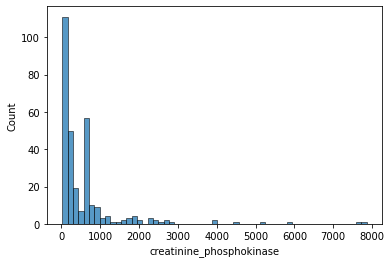

In [245]:
# outlier가 3000이상으로 분포되어 있음
sns.histplot(data=df['creatinine_phosphokinase'])

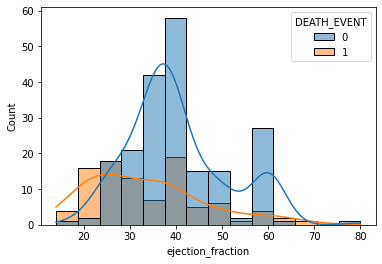

In [246]:
# bins을 조정하여 그래프를 촘촘하게 만듦
# ejection이 낮은 값 중 DEATH_EVENT가 1인 경우가 많음 -> precision에 용이
# but DEATH_EVENT가 1인 경우는 넓게 분포 되어 있음 -> recall에 도움x
sns.histplot(x='ejection_fraction', data=df, bins=14, hue='DEATH_EVENT', kde=True)

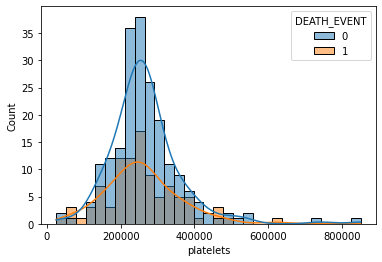

In [247]:
# 골고루 분포되어 있지만 DEATH_EVENT와 관계 없음
sns.histplot(x='platelets', data=df, hue='DEATH_EVENT', kde=True)

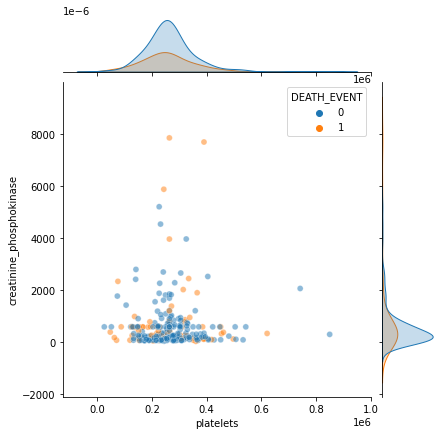

In [248]:
# scatter, histogram
sns.jointplot(x='platelets', y='creatinine_phosphokinase',data=df, hue='DEATH_EVENT', alpha=0.5)

#### Boxplot 계열을 이용하여 범주별 통계 확인하기


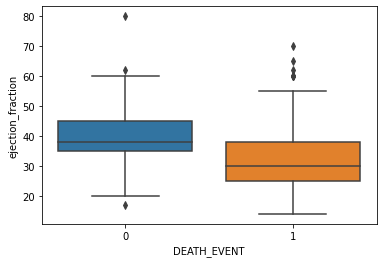

In [249]:
# boxplot
# outlier를 처리해 줌
# 경영측에서 많이 사용하는 시각화 방식(ppt에 사용하면)
sns.boxplot(x='DEATH_EVENT', y='ejection_fraction', data=df)

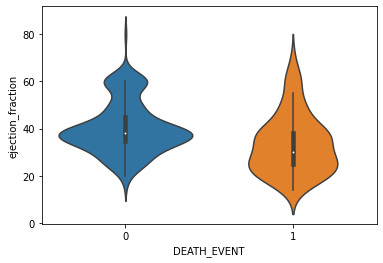

In [250]:
# violinplot: boxplot + histogram
# 자주 사용되지 않음
sns.violinplot(x='DEATH_EVENT', y='ejection_fraction', data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


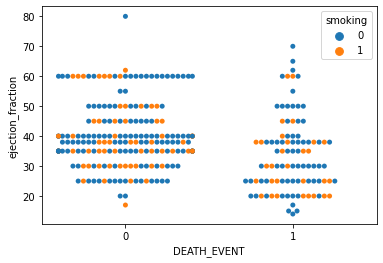

In [251]:
# swarmplot: scatterplot + violinplot
# hue를 통해 나눠진 데이터에서 또 분할 가능
sns.swarmplot(x='DEATH_EVENT', y='ejection_fraction', hue='smoking',data=df)

## Step 3. 모델 학습을 위한 데이터 전처리


#### 데이터 전처리(스케일링)


In [252]:
from sklearn.preprocessing import StandardScaler

# 수치형 입력 데이터, 범주형 입력 데이터, 출력 데이터로 구분하기
x_numeric = df[['age', 'creatinine_phosphokinase',
       'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time']]
x_category = df[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']]
y = df['DEATH_EVENT']

In [253]:
# from sklearn.preprocessing import MinMaxScaler
# X = df[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
#        'ejection_fraction', 'high_blood_pressure', 'platelets',
#        'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']]
# y = df['DEATH_EVENT']

# scaler = MinMaxScaler()
# X_scaled = scaler.transform(X)
# X = pd.concat([X_scaled, X_category], axis=1)

In [254]:
scaler = StandardScaler()
scaler.fit(x_numeric)
x_scaled = scaler.transform(x_numeric)

x_numeric = pd.DataFrame(data=X_scaled, index=x_numeric.index, columns=x_numeric.columns)
x = pd.concat([x_numeric, X_category], axis=1)
x

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,0,1,1,0
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1,0
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,0,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1,0
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.537688,-0.007077,-1.109765e+00,-0.284552,1.447094,1.803451,0,1,1,1,1
295,-0.491279,1.278215,-0.007077,6.802472e-02,-0.187726,0.539054,1.816357,0,0,0,0,0
296,-1.333392,1.525979,1.854958,4.902082e+00,-0.575031,0.312044,1.906697,0,1,0,0,0
297,-1.333392,1.890398,-0.007077,-1.263389e+00,0.005926,0.766064,1.932509,0,0,0,1,1


#### 학습데이터와 테스트데이터 분리하기


In [259]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## Step 4. Classification 모델 학습하기


#### Logistic Regression 모델 생성/학습하기


In [270]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=100)
model_lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### 모델 학습 결과 평가하기


In [281]:
from sklearn.metrics import classification_report

pred = model_lr.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        64
           1       0.76      0.62      0.68        26

    accuracy                           0.83        90
   macro avg       0.81      0.77      0.78        90
weighted avg       0.83      0.83      0.83        90



#### XGBoost 모델 생성/학습하기


In [276]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### 모델 학습 결과 평가하기


In [278]:
pred = model_xgb.predict(x_test) 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        64
           1       0.90      0.73      0.81        26

    accuracy                           0.90        90
   macro avg       0.90      0.85      0.87        90
weighted avg       0.90      0.90      0.90        90

0.9


#### 특징의 중요도 확인하기


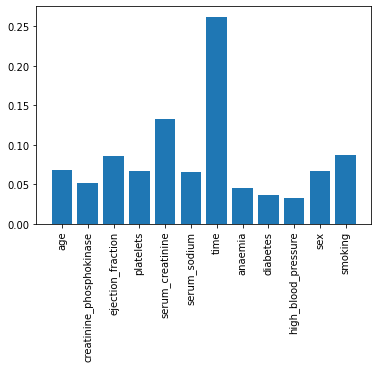

In [284]:
# plt.plot(model_xgb.feature_importances_)
plt.bar(x.columns, model_xgb.feature_importances_)
plt.xticks(rotation=90)
plt.show()
# time이 중요도가 가장 높은데 결과론적으로
# DEATH_EVENT가 1인 데이터는 time이 짧을 수 밖에 없는 상황임
# -> time에는 DEATH_EVENT의 정보를 내포함 -> time data 제거하는게 맞음

## Step5 모델 학습 결과 심화 분석하기


#### Precision-Recall 커브 확인하기

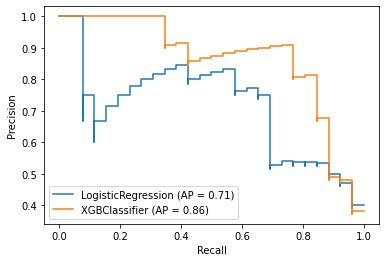

In [285]:
from sklearn.metrics import plot_precision_recall_curve

fig = plt.figure()
plot_precision_recall_curve(model_lr, x_test, y_test, ax=fig.gca())
plot_precision_recall_curve(model_xgb, x_test, y_test, ax=fig.gca())

#### ROC 커브 확인하기

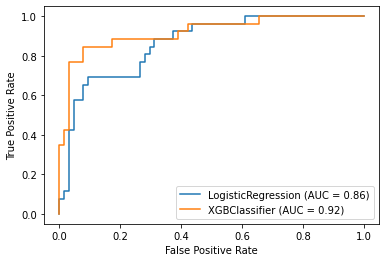

In [287]:
from sklearn.metrics import plot_roc_curve

fig = plt.figure()
plot_roc_curve(model_lr, x_test, y_test, ax=fig.gca())
plot_roc_curve(model_xgb, x_test, y_test, ax=fig.gca())